[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrrajeshreddy/TGS-Salt-Identification/blob/master/TGS_salt_identification.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import os
import functools
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img


In [2]:
source_dir = './tgs-salt-identification-challenge'
train_images_dir = os.path.join(source_dir,'train','images')
train_masks_dir = os.path.join(source_dir,'train','masks')
print('Training images:', train_images_dir)
print('Training masks:', train_masks_dir)

Training images: ./tgs-salt-identification-challenge/train/images
Training masks: ./tgs-salt-identification-challenge/train/masks


In [0]:
def load_data(target_size=(128,128), test_size=0.1):
  train_df = pd.read_csv( os.path.join(source_dir,'train.csv') )
  train_df.count()
  
  def _get_name(idx, path_name):
    file_name = "{}.png".format(idx)
    file_name = os.path.join(path_name, file_name)
    return file_name  

  train_images = []
  train_masks = []
  for idx in train_df.id:
    image_path = _get_name(idx, train_images_dir)
    mask_path = _get_name(idx, train_masks_dir)
    image= img_to_array(load_img(image_path, color_mode = "grayscale", target_size=target_size))
    mask = img_to_array(load_img(mask_path,color_mode = "grayscale", target_size=target_size))
    train_images.append(image)
    train_masks.append(mask)
  train_images = np.array(train_images)
  train_masks = np.array(train_masks)  
  
  x_train, x_val, y_train, y_val = train_test_split( train_images, train_masks, test_size=test_size )
  
  return (x_train, y_train),(x_val, y_val)

In [4]:
(x_train, y_train),(x_val, y_val) = load_data()
print('Total training sample:', x_train.shape[0])
print('Total validation sample:', x_val.shape[0])

Total training sample: 3600
Total validation sample: 400


In [0]:
def vis_data(images, masks, num_samples=10):
  grid_count = 0
  choice = np.random.choice(images.shape[0], num_samples)
  plt.figure(figsize=(3*2,num_samples*2))
  grid_spec = gridspec.GridSpec(num_samples, 3, hspace=0.1, wspace=0.01 )
  for indx in choice:
    img = images[indx] / 255
    msk = masks[indx] / 255
    
    plt.subplot(grid_spec[grid_count,0] )
    plt.imshow(img[:,:,0], cmap='gray')
    plt.axis('off')
    
    plt.subplot(grid_spec[grid_count,1])
    plt.imshow(msk[:,:,0], cmap='gray')
    plt.axis('off')
    
    plt.subplot(grid_spec[grid_count,2])
    plt.imshow(img[:,:,0])
    plt.imshow(msk[:,:,0], alpha=0.2, cmap="seismic")
    plt.axis('off')
    
    grid_count += 1
  
  plt.show()
    

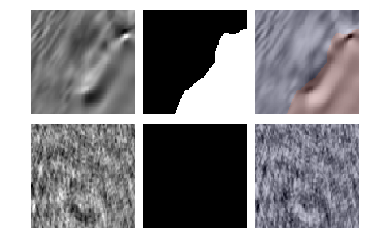

In [7]:
vis_data(x_train, y_train, 2)

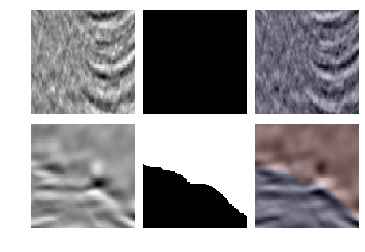

In [8]:
vis_data(x_val, y_val, 2)

In [0]:
img_shape = (128, 128, 1)
batch_size = 8
epochs = 100

In [0]:
def _scale(image, label, scale=1/255):
  label_img = label * scale
  image = image * scale
  return image, label_img

In [0]:
def _image_flip(image, label, horizontal_flip):
  if horizontal_flip:
      flip_prob = tf.random_uniform([], 0.0, 1.0)
      image, label = tf.cond(tf.less(flip_prob, 0.5),
                              lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
                              lambda: (image, label))
  return image, label

In [0]:
def _image_shift(image, label, width_shift_range, height_shift_range):
  if width_shift_range or height_shift_range:
      if width_shift_range:
          width_shift_range = tf.random_uniform([], 
                                            -width_shift_range * img_shape[1],
                                            width_shift_range * img_shape[1])
      if  height_shift_range:
          height_shift_range = tf.random_uniform([],
                                             -height_shift_range * img_shape[0],
                                             height_shift_range * img_shape[0])
      image = tfcontrib.image.translate(image,
                                           [width_shift_range, height_shift_range])
      label = tfcontrib.image.translate(label,
                                           [width_shift_range, height_shift_range])
  return image, label

In [0]:
def _augment(image, 
             label,
             scale=1,
             horizontal_flip=False,
             width_shift_range=0,
             height_shift_range=0
            ):
  image, label = _image_flip(image, label, horizontal_flip)
  image, label = _image_shift(image, label, width_shift_range, height_shift_range)
  image, label = _scale(image, label, scale=scale)
  return image, label

In [0]:
def get_dataset(images,
                labels, 
                threads=5, 
                batch_size=10,
                shuffle=True,
                preproc_fn=functools.partial(_augment),
                resize=True,
                scale=1/255,
               ):
    num_x = 20
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
    if shuffle:
        dataset = dataset.shuffle(num_x)
    
    dataset = dataset.repeat().batch(batch_size ) #, drop_remainder=True)
    return dataset

In [0]:
tr_cfg = {
    'scale': 1 / 255.,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [0]:
val_cfg = {
    'scale': 1 / 255.,
    'horizontal_flip': False,
    'width_shift_range': None,
    'height_shift_range': None
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)


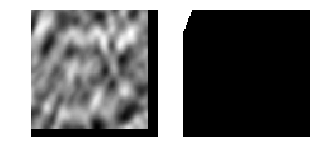

In [34]:
temp_ds = get_dataset(x_train, 
                      y_train,
                      preproc_fn=tr_preprocessing_fn,
                      batch_size=1,
                      shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
    imgs, lbls = sess.run(next_element)
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[0,:,:,0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(lbls[0,:,:,0], cmap='gray')
    plt.axis('off')
    plt.show()

In [0]:
def conv_block(input_tensor, num_filters):
  encoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [0]:
def get_model():
  inputs = layers.Input(shape=img_shape )
  encoder0_pool, encoder0 = encoder_block(inputs, 32)
  encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
  encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
  encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
  center = conv_block(encoder3_pool, 512)
  decoder3 = decoder_block(center, encoder3, 256)
  decoder2 = decoder_block(decoder3, encoder2, 128)
  decoder1 = decoder_block(decoder2, encoder1, 64)
  decoder0 = decoder_block(decoder1, encoder0, 32)
  outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
  model = models.Model(inputs=[inputs], outputs=[outputs])
  return model

In [0]:
def dice_coeff(y_true, y_pred):
  smooth = 1.
  # Flatten
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return score

In [0]:
def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
  loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
  return loss

In [0]:
def iou_coef(y_true, y_pred):
  smooth = 1.
  # Flatten
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  union = (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)) - intersection
  loss = (intersection + smooth) / ( union + smooth)
  return loss

In [69]:
K.clear_session()
model = get_model()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss, iou_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 128, 128, 32) 73          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         separable_conv2d[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
separable_

In [0]:
train_ds = get_dataset(x_train,
                       y_train,
                       preproc_fn=tr_preprocessing_fn,
                       batch_size=batch_size)
val_ds = get_dataset(x_val,
                     y_val, 
                     preproc_fn=val_preprocessing_fn,
                     batch_size=batch_size)

In [0]:
num_train_examples = x_train.shape[0]
num_val_examples = x_val.shape[0]

In [0]:
save_weight_path = './gdrive/My Drive/model/TGS_model.h5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_weight_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [73]:
history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                    callbacks=[cp])

Epoch 1/100
449/450 [============================>.] - ETA: 0s - loss: 6.4103 - dice_loss: 0.4271 - iou_coef: 0.4197
Epoch 00001: val_dice_loss improved from inf to 0.60537, saving model to ./gdrive/My Drive/model/TGS_model.h5
450/450 [==============================] - 93s 206ms/step - loss: 6.4112 - dice_loss: 0.4270 - iou_coef: 0.4197 - val_loss: 12.9803 - val_dice_loss: 0.6054 - val_iou_coef: 0.2552
Epoch 2/100
449/450 [============================>.] - ETA: 0s - loss: 5.2517 - dice_loss: 0.3436 - iou_coef: 0.5082
Epoch 00002: val_dice_loss improved from 0.60537 to 0.39518, saving model to ./gdrive/My Drive/model/TGS_model.h5
450/450 [==============================] - 83s 184ms/step - loss: 5.2491 - dice_loss: 0.3434 - iou_coef: 0.5083 - val_loss: 7.4353 - val_dice_loss: 0.3952 - val_iou_coef: 0.4697
Epoch 3/100
449/450 [============================>.] - ETA: 0s - loss: 4.7072 - dice_loss: 0.3108 - iou_coef: 0.5466
Epoch 00003: val_dice_loss did not improve from 0.39518
450/450 [===

Text(0.5,1,'Training and Validation loss')

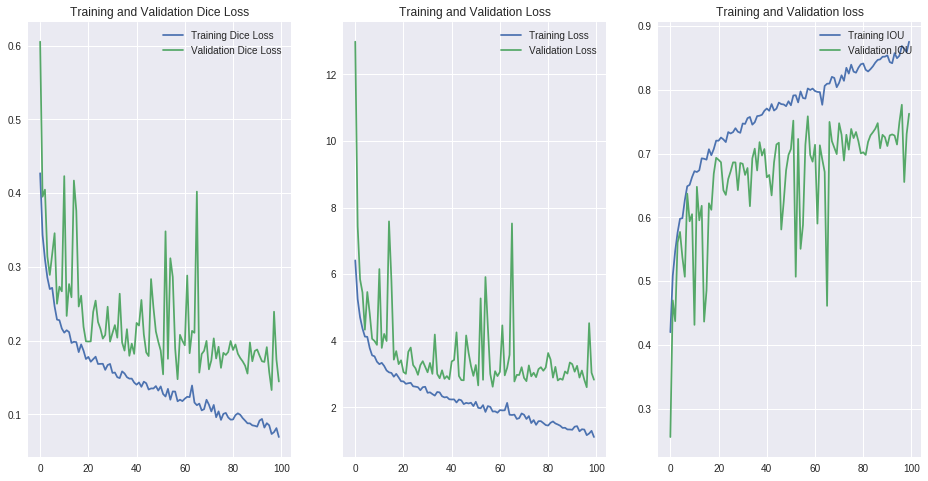

In [74]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

iou = history.history['iou_coef']
val_iou = history.history['val_iou_coef']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, iou, label='Training IOU')
plt.plot(epochs_range, val_iou, label='Validation IOU')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')